# 프로젝트: 주식 예측해보기
## 🎯 평가기준
1. 시계열의 stationary 확인
2. ARIMA 모델 모수 선택 근거 제시
3. 3개 이상 종목의 예측 모델 오차율이 기준 이하(MAPE 15% 미만)로 예측

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

ADF Test로 시계열 데이터의 stationary를 테스트하는 함수

In [232]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey-Fuller Test: ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#원본시계열, 이동평균, 이동표준편차를 plot으로 시각화하는 함수

In [233]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

train과 test를 분리하는 함수

In [234]:
def split_train_test(ts, test_size=0.2):
    train_size = int(len(ts)*(1-test_size))    
    return ts[:train_size], ts[train_size:]

정확도 측정하는 함수

In [235]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def accuracy_measure(ts_test, forecast):    
    mse = mean_squared_error(np.exp(ts_test), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(ts_test), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(ts_test), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(ts_test))/np.abs(np.exp(ts_test)))
    print('MAPE: {:.2f}%'.format(mape*100))

# Samsung 예측 

## 1. 데이터 로드

In [236]:
ts.index.min(), ts.index.max()

(Timestamp('2020-09-07 00:00:00'), Timestamp('2021-09-06 00:00:00'))

In [237]:
stockpath = os.getenv('HOME')+'/aiffel/stock_prediction/005930.KS.csv'
ts = pd.read_csv(stockpath, index_col='Date', parse_dates=True)
ts = ts['Close']
ts.head(10)

Date
2020-09-07    56500.0
2020-09-08    58700.0
2020-09-09    58400.0
2020-09-10    59200.0
2020-09-11    59000.0
2020-09-14    60400.0
2020-09-15    61000.0
2020-09-16    61000.0
2020-09-17    59500.0
2020-09-18    59300.0
Name: Close, dtype: float64

## 2. 전처리
### 결측치 처리

Series([], Name: Close, dtype: float64)


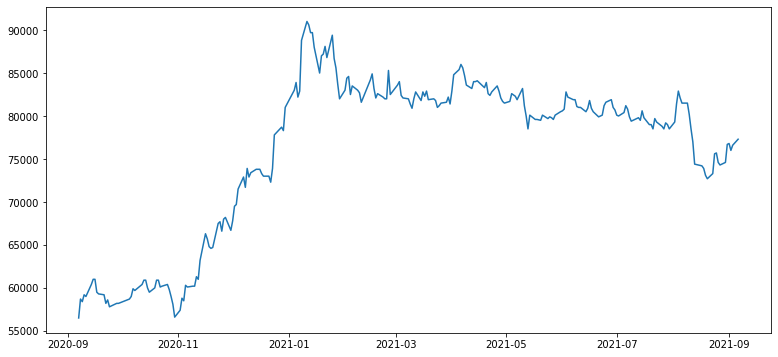

In [238]:
ts=ts.interpolate(method='time')
print(ts[ts.isna()])
plt.plot(ts)

In [239]:
adf_test(ts)

Results of Dickey-Fuller Test: 
Test Statistic                  -2.149826
p-value                          0.224957
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


### 로그 변환

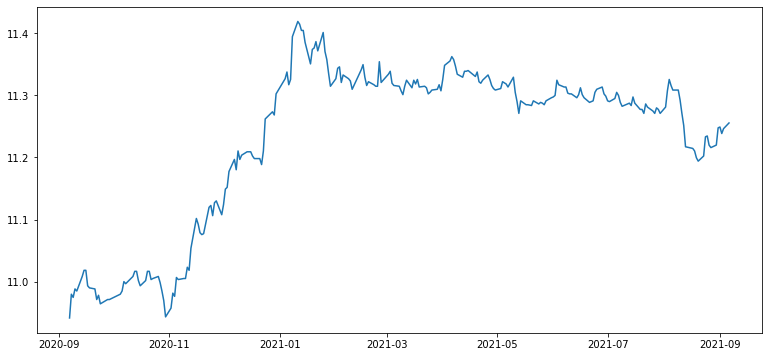

In [240]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [241]:
adf_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                  -2.306020
p-value                          0.170034
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


로그변환을 하니 0.22->0.17로 p-value가 줄어들었다. 따라서 로그변환을 한 것이 더 안정적이라고 해석할 수 있다.

## 3. 시계열 안정성 분석

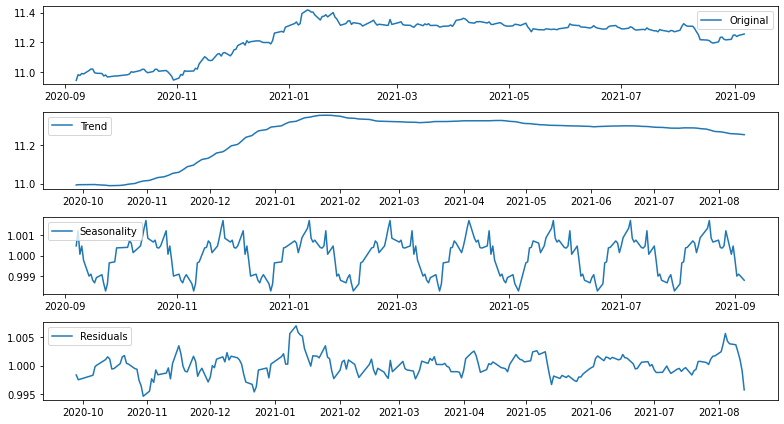

In [242]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [243]:
residual.dropna(inplace=True)
adf_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -5.945188e+00
p-value                        2.212781e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


residual 안정성을 확인했을 때 p-value가 로그변환까지 했던 것 보다 더 줄어들어 0.17->0.0000002까지 감소하였다.

## 4. 적정 ARIMA 모수 찾기 

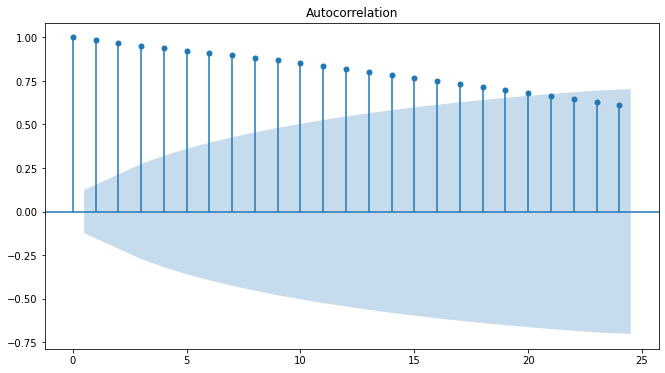

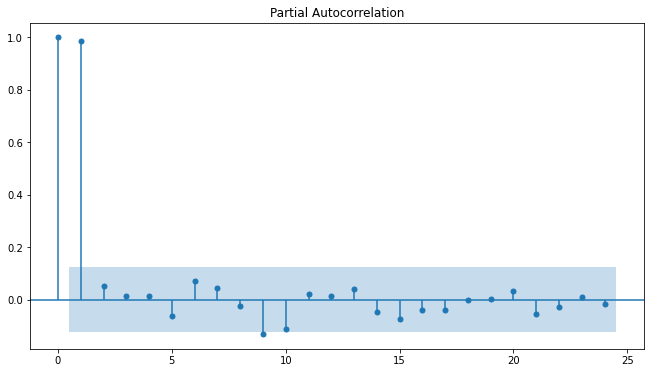

In [244]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF : 시차에 따른 자기상관을 의미하며, 시차가 커질수록 ACF는 0에 가까워진다. 정상 시계열은 상대적으로 빠르게 0에 수렴하며, 비정상 시계열은 천천히 감소하고, 종종 큰 값을 가진다. -> MA모델의 시차 q를 결정
    - 위 그래프를 보아 아주 느리게 감소하고 있다.
* PACF : 시차에 따른 편자기상관. 시차가 다른 두 시계열 데이터 간 순수한 상호 연관성 -> AR모델의 시차 p를 결정
    - 시차가 2 이상일 때 0에 가까워진다.
    
<img width="640" alt="스크린샷 2021-09-07 오전 12 47 21" src="https://user-images.githubusercontent.com/63278762/132241071-f68be650-a730-4988-971a-ccfe772c1b7a.png">

    
q는 적합한 값이 없기 때문에 고려하지 않고, p=2로 설정한다.    
여기서는 추가적인 실험을 위해 p=3도 시도해보려고 한다.

Results of Dickey-Fuller Test: 
Test Statistic                -1.138842e+01
p-value                        8.180886e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


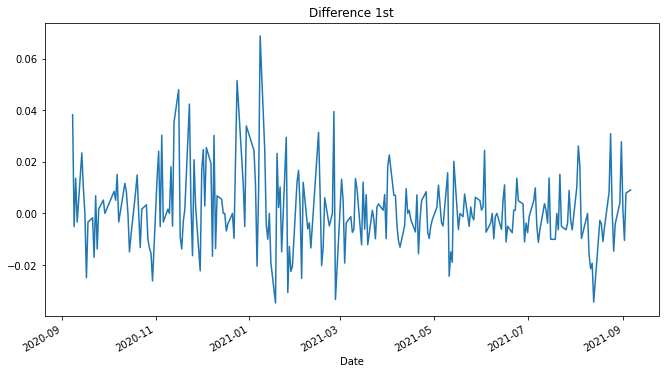

In [245]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

adf_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -1.079494e+01
p-value                        2.087122e-19
#Lags Used                     7.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


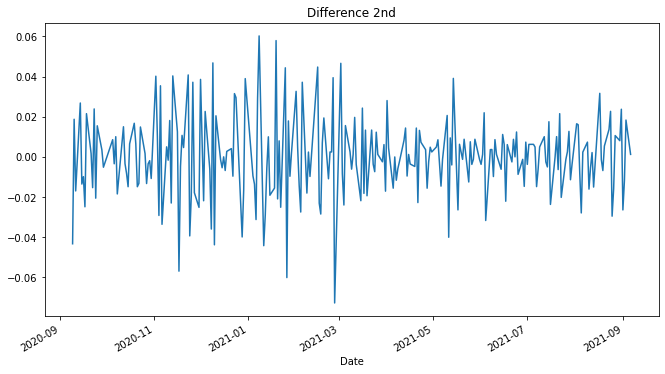

In [246]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

adf_test(diff_2)

2차 차분을 한 것이 더 0에 가까울 것이라 예상했는데 1차 차분이 더 0에 가까우므로 d=1으로 설정한다.

#### ✅ p=2, q=0, d=1
#### ✅ p=3, q=0, d=1

## 5. 학습, 테스트 데이터셋 생성

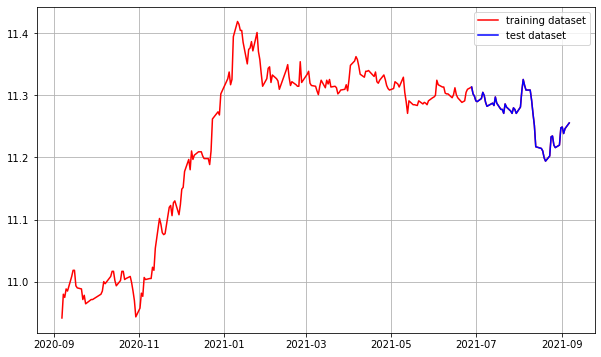

In [247]:
train_data, test_data = split_train_test(ts_log)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

모델링을 마친 후 잔차의 ACF그래프를 그려 정상성을 따르는지 확인해야 한다. 만약, 정상성을 따르지 않는다면, p,d,q의 파라미터를 재조정해서 다시 모델링 해야 한다.

## 6. ARIMA 모델 훈련과 테스트

#### ✅ p=2, q=0, d=1

In [248]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  197
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 541.936
Method:                       css-mle   S.D. of innovations              0.015
Date:                Mon, 06 Sep 2021   AIC                          -1075.872
Time:                        16:17:59   BIC                          -1062.739
Sample:                             1   HQIC                         -1070.556
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.001      1.755      0.079      -0.000       0.004
ar.L1.D.Close     0.0327      0.072      0.455      0.649      -0.108       0.174
ar.L2.D.Close    -0.0747      0.072     

<Figure size 720x432 with 0 Axes>

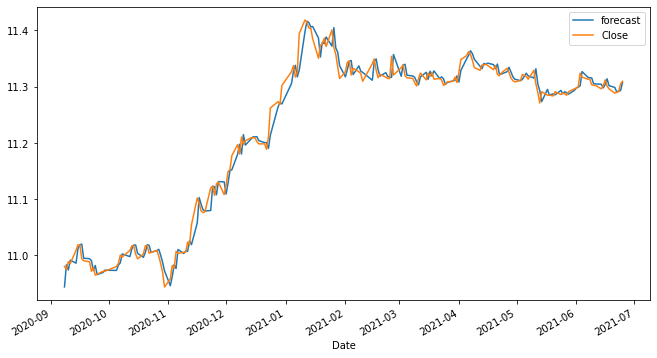

In [249]:
# ARIMA훈련 결과 시각화
plt.figure(figsize=(10,6))
fitted_m.plot_predict()
plt.show()

테스트 데이터 구간의 데이터를 예측해본다.

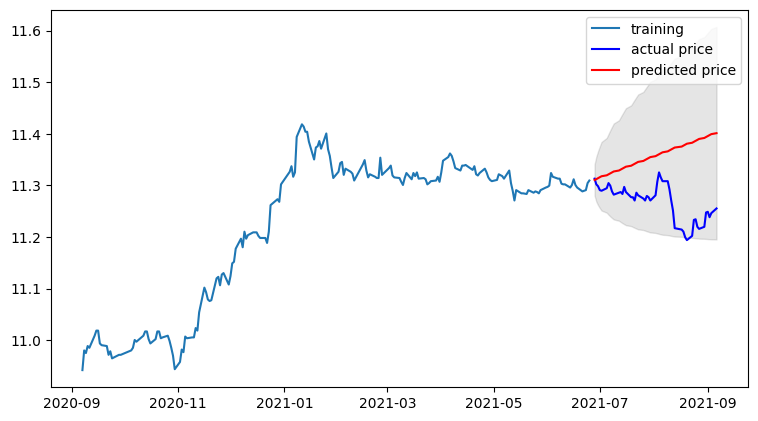

In [250]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [251]:
accuracy_measure(test_data, fc)

MSE:  71742189.43806235
MAE:  7141.579487437044
RMSE:  8470.076117607347
MAPE: 9.31%


오차율 9.31%를 보이고 있다.    
마지막으로 잔차 분석을 통해 문제가 없는지 확인한다. 잔차는 어떠한 패턴이나 특성이 나타나면 안된다.

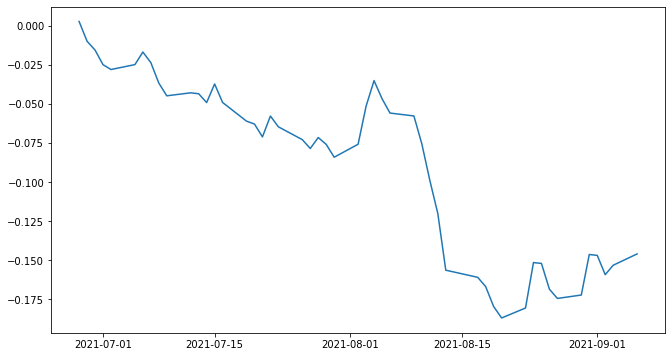

In [252]:
diff = np.array(test_data)-np.array(fc_series)
plt.plot(fc_series.index, diff)

<Figure size 720x432 with 0 Axes>

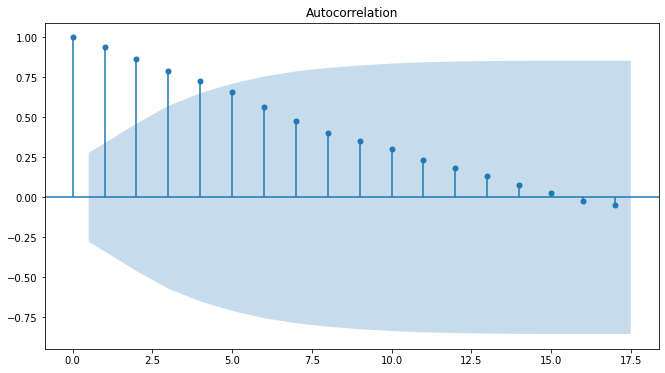

In [253]:
plt.figure(figsize=(10,6))
plot_acf(diff)
plt.show()

#### ✅ p=3, q=0, d=1

In [254]:
model = ARIMA(train_data, order=(3, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  197
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 542.014
Method:                       css-mle   S.D. of innovations              0.015
Date:                Mon, 06 Sep 2021   AIC                          -1074.029
Time:                        16:18:00   BIC                          -1057.613
Sample:                             1   HQIC                         -1067.384
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.001      1.713      0.087      -0.000       0.004
ar.L1.D.Close     0.0352      0.072      0.487      0.626      -0.106       0.177
ar.L2.D.Close    -0.0759      0.072     

<Figure size 720x432 with 0 Axes>

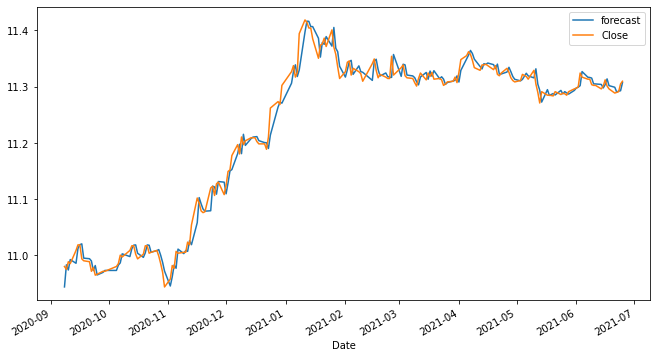

In [255]:
# ARIMA훈련 결과 시각화
plt.figure(figsize=(10,6))
fitted_m.plot_predict()
plt.show()

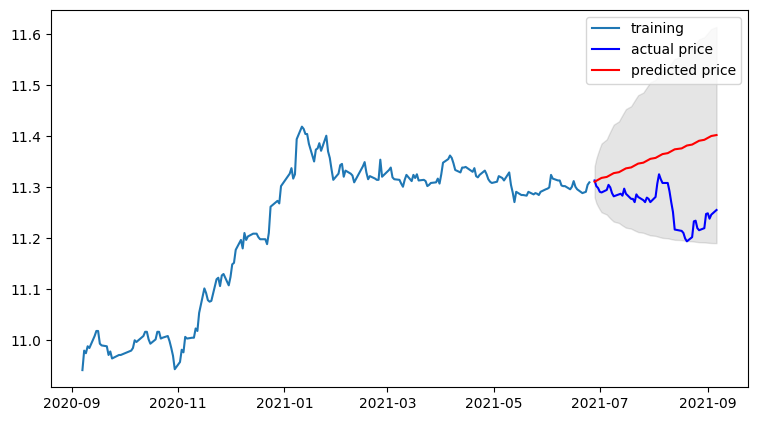

In [256]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [257]:
accuracy_measure(test_data, fc)

MSE:  72528493.17800814
MAE:  7189.467636925206
RMSE:  8516.366195626404
MAPE: 9.37%


p=2, q=0, d=1 의 MAPE가 9.31%였으니 p=3, q=0, d=1의 MAPE가 9.37%로 조금 더 오차율이 높은 것을 볼 수 있다.

### 최종적으로 예측한 값
p=2, q=0, d=1 일때의 ARIMA 모델
MAPE: 9.31

# Kakao 예측 

## 1. 데이터 로드

In [259]:
stockpath = os.getenv('HOME')+'/aiffel/stock_prediction/035720.KS.csv'
ts = pd.read_csv(stockpath, index_col='Date', parse_dates=True)
ts = ts['Close']
ts.head(10)

Date
2020-09-07    78400.0
2020-09-08    78000.0
2020-09-09    76800.0
2020-09-10    77100.0
2020-09-11    75800.0
2020-09-14    74700.0
2020-09-15    76200.0
2020-09-16    75400.0
2020-09-17    74200.0
2020-09-18    74600.0
Name: Close, dtype: float64

## 2. 전처리
### 결측치 처리

Series([], Name: Close, dtype: float64)


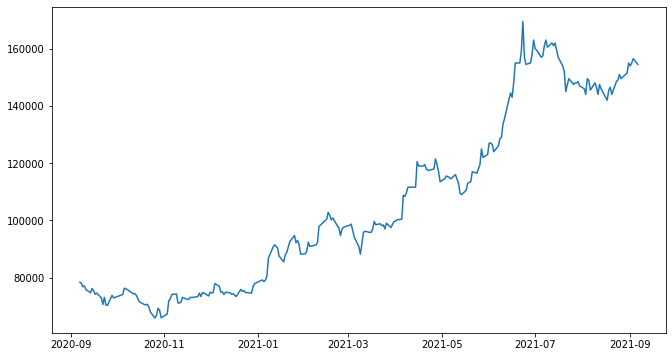

In [260]:
ts=ts.interpolate(method='time')
print(ts[ts.isna()])
plt.plot(ts)

In [261]:
adf_test(ts)

Results of Dickey-Fuller Test: 
Test Statistic                   0.037132
p-value                          0.961497
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


### 로그 변환

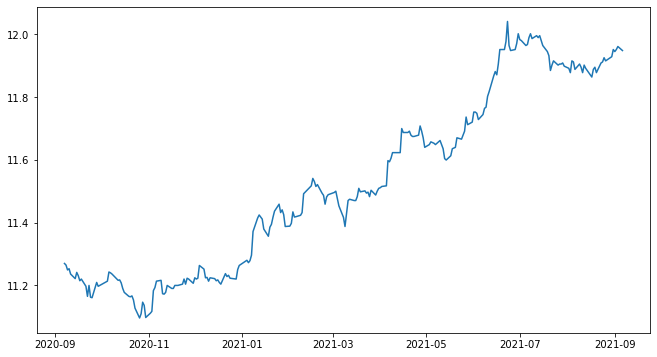

In [262]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [263]:
adf_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                  -0.061448
p-value                          0.953146
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


카카오는 신기하게 로그변환을 해도 p-value가 소폭 감소했다.

## 3. 시계열 안정성 분석

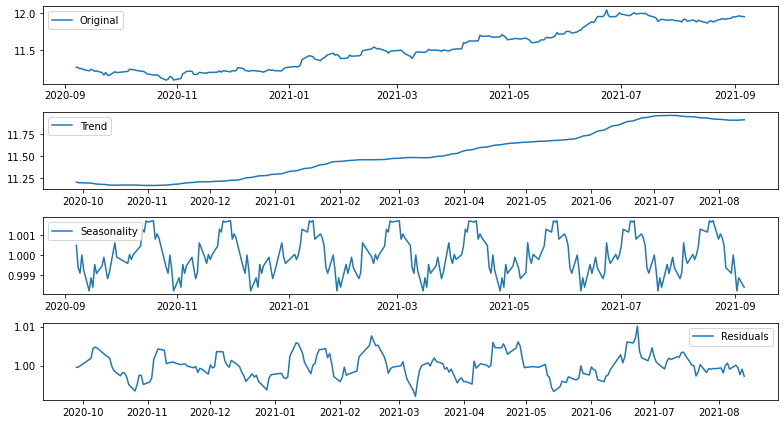

In [264]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [265]:
residual.dropna(inplace=True)
adf_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                  -5.177077
p-value                          0.000010
#Lags Used                       1.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


residual 안정성을 확인했을 때 p-value가 로그변환까지 했던 것 보다 많이 줄어들어 0.000010까지 줄어들었다.

## 4. 적정 ARIMA 모수 찾기 

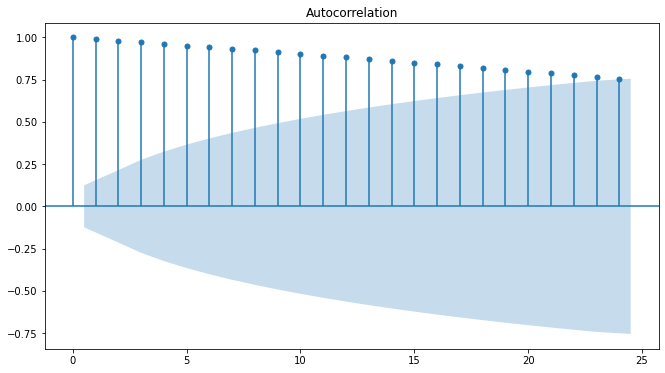

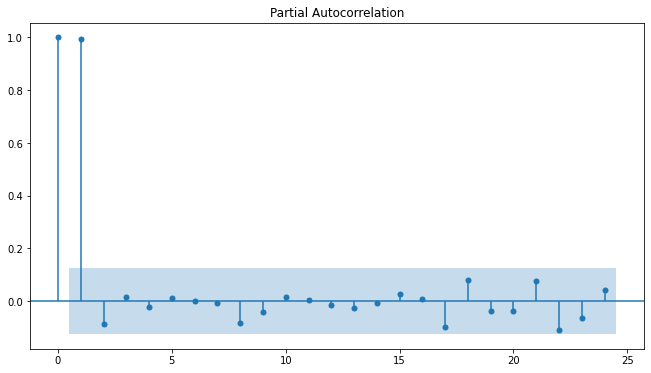

In [266]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF : 위 그래프를 보아 아주 느리게 감소하고 있다.
* PACF : 시차가 2 이상일 때 0에 가까워진다.
    
q는 적합한 값이 없기 때문에 고려하지 않고, p=2로 설정한다.    
여기서는 추가적인 실험을 위해 p=3도 시도해보려고 한다.

Results of Dickey-Fuller Test: 
Test Statistic                -1.472046e+01
p-value                        2.757167e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


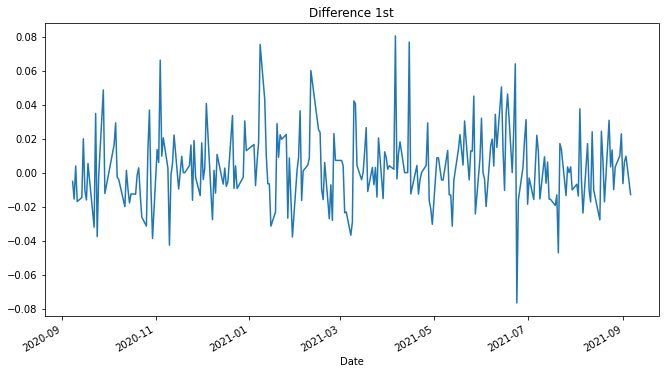

In [267]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

adf_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -8.314560e+00
p-value                        3.710796e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


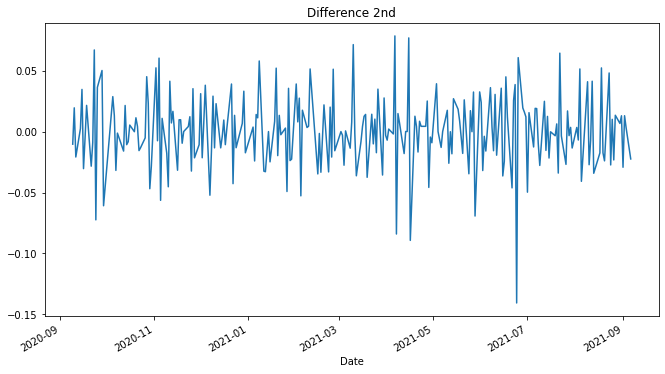

In [268]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

adf_test(diff_2)

1차 차분이 더 0에 가까우므로 d=1으로 설정한다.

#### ✅ p=2, q=0, d=1
#### ✅ p=3, q=0, d=1

## 5. 학습, 테스트 데이터셋 생성

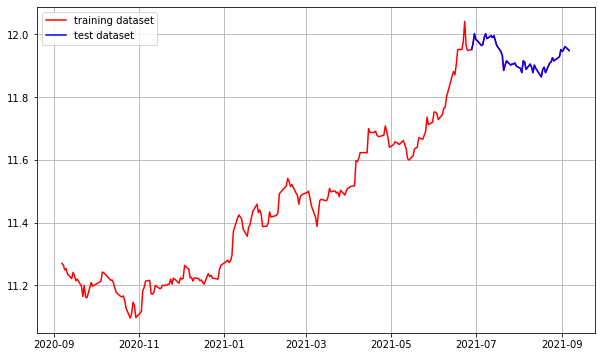

In [269]:
train_data, test_data = split_train_test(ts_log)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 6. ARIMA 모델 훈련과 테스트

#### ✅ p=2, q=0, d=1

In [270]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  197
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 465.626
Method:                       css-mle   S.D. of innovations              0.023
Date:                Mon, 06 Sep 2021   AIC                           -923.252
Time:                        16:22:35   BIC                           -910.119
Sample:                             1   HQIC                          -917.935
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0035      0.002      2.030      0.042       0.000       0.007
ar.L1.D.Close     0.0824      0.071      1.158      0.247      -0.057       0.222
ar.L2.D.Close    -0.0356      0.073     

<Figure size 720x432 with 0 Axes>

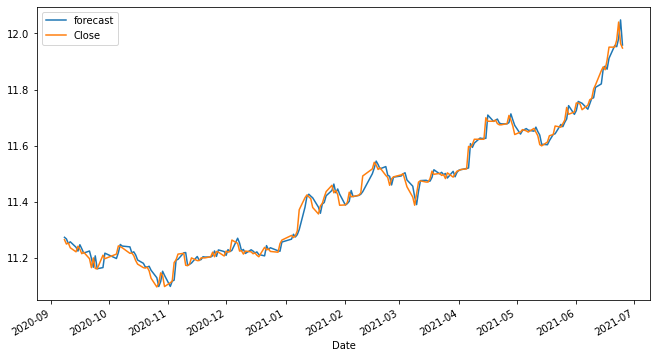

In [271]:
# ARIMA훈련 결과 시각화
plt.figure(figsize=(10,6))
fitted_m.plot_predict()
plt.show()

테스트 데이터 구간의 데이터를 예측해본다.

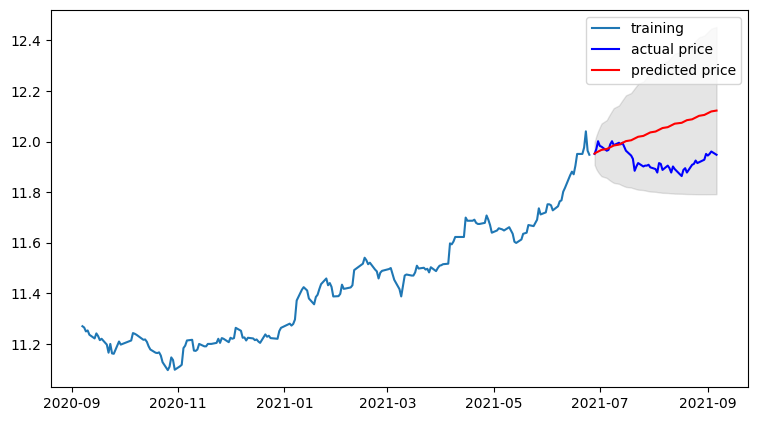

In [272]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [273]:
accuracy_measure(test_data, fc)

MSE:  458459096.7323735
MAE:  18066.352951314173
RMSE:  21411.65796318383
MAPE: 12.14%


오차율 12.14%를 보이고 있다.    

#### ✅ p=3, q=0, d=1

In [276]:
model = ARIMA(train_data, order=(3, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  197
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 465.702
Method:                       css-mle   S.D. of innovations              0.023
Date:                Mon, 06 Sep 2021   AIC                           -921.404
Time:                        16:23:32   BIC                           -904.988
Sample:                             1   HQIC                          -914.759
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0034      0.002      1.971      0.049    1.87e-05       0.007
ar.L1.D.Close     0.0831      0.071      1.168      0.243      -0.056       0.222
ar.L2.D.Close    -0.0392      0.074     

<Figure size 720x432 with 0 Axes>

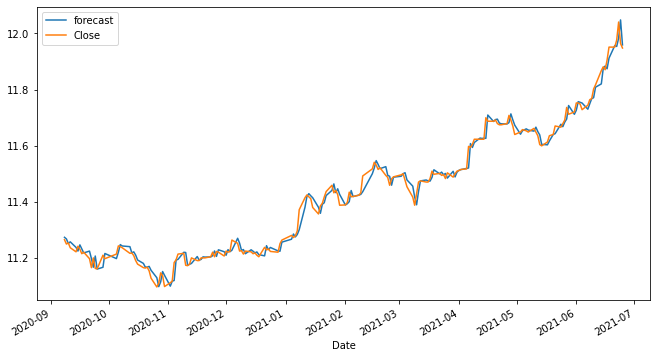

In [277]:
# ARIMA훈련 결과 시각화
plt.figure(figsize=(10,6))
fitted_m.plot_predict()
plt.show()

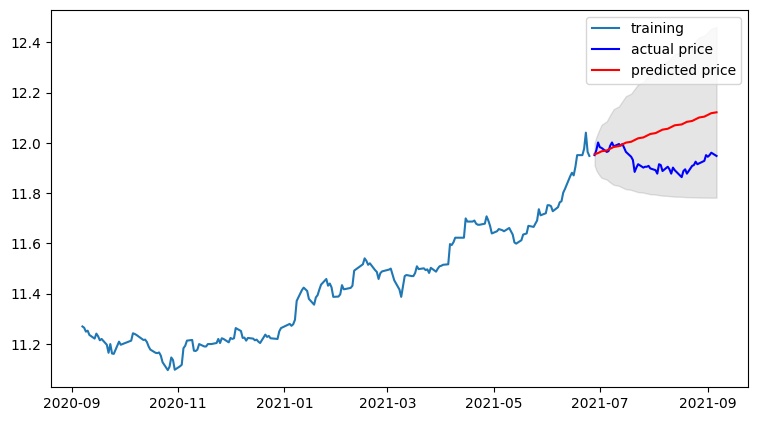

In [278]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [279]:
accuracy_measure(test_data, fc)

MSE:  451878392.4835125
MAE:  17949.935160045246
RMSE:  21257.43146486688
MAPE: 12.06%


p=2, q=0, d=1 의 MAPE가 12.14%였으나 p=3, q=0, d=1의 MAPE가 12.06%로 약간 줄어든 것을 볼 수 있다.    
마지막으로 잔차 분석을 통해 문제가 없는지 확인한다. 잔차는 어떠한 패턴이나 특성이 나타나면 안된다.

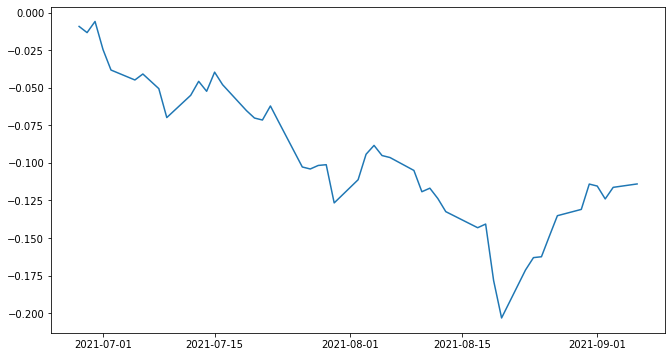

In [304]:
diff = np.array(test_data)-np.array(fc_series)
plt.plot(fc_series.index, diff)

<Figure size 720x432 with 0 Axes>

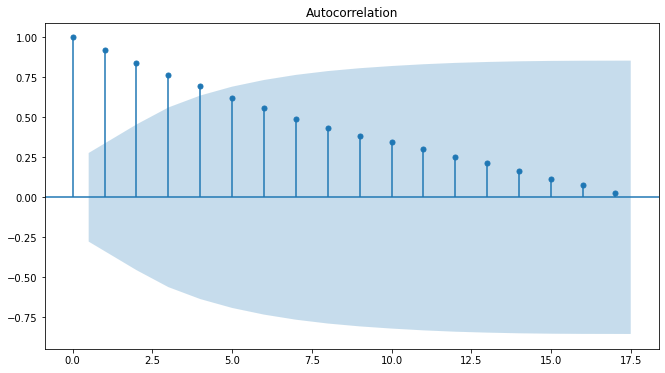

In [305]:
plt.figure(figsize=(10,6))
plot_acf(diff)
plt.show()

ACF의 그래프가 빠르게 0에 수렴하는 것을 볼 수 있다.

### 최종적으로 예측한 값
p=3, q=0, d=1 일때의 ARIMA 모델
MAPE: 12.06

# Hyundai Mobis 예측

## 1. 데이터 로드

In [314]:
stockpath = os.getenv('HOME')+'/aiffel/stock_prediction/012330.KS.csv'
ts = pd.read_csv(stockpath, index_col='Date', parse_dates=True)
ts = ts['Close']
ts.head(10)

Date
2020-09-07    225500.0
2020-09-08    225500.0
2020-09-09    223500.0
2020-09-10    224000.0
2020-09-11    226000.0
2020-09-14    232500.0
2020-09-15    234000.0
2020-09-16    242500.0
2020-09-17    242000.0
2020-09-18    240000.0
Name: Close, dtype: float64

## 2. 전처리
### 결측치 처리

Series([], Name: Close, dtype: float64)


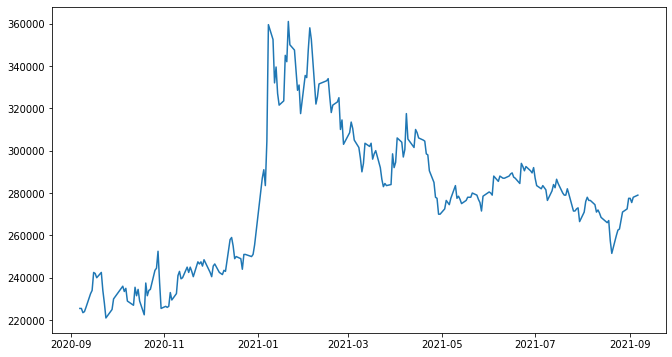

In [315]:
ts=ts.interpolate(method='time')
print(ts[ts.isna()])
plt.plot(ts)

In [316]:
adf_test(ts)

Results of Dickey-Fuller Test: 
Test Statistic                  -2.009696
p-value                          0.282338
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


### 로그 변환

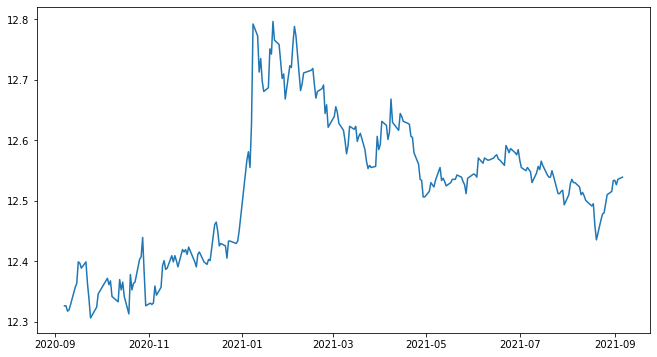

In [317]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [318]:
adf_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                  -2.035291
p-value                          0.271317
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


## 3. 시계열 안정성 분석

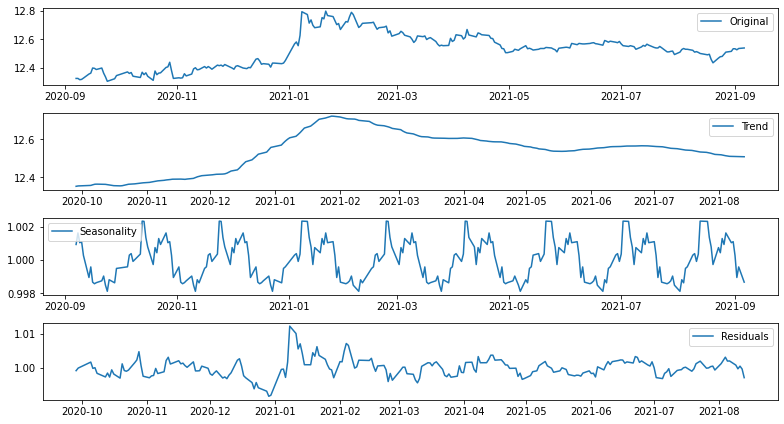

In [319]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [320]:
residual.dropna(inplace=True)
adf_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                  -3.756474
p-value                          0.003385
#Lags Used                      13.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


p-value가 0.271317->0.003385로 줄어든 것을 볼 수 있다.

## 4. 적정 ARIMA 모수 찾기 

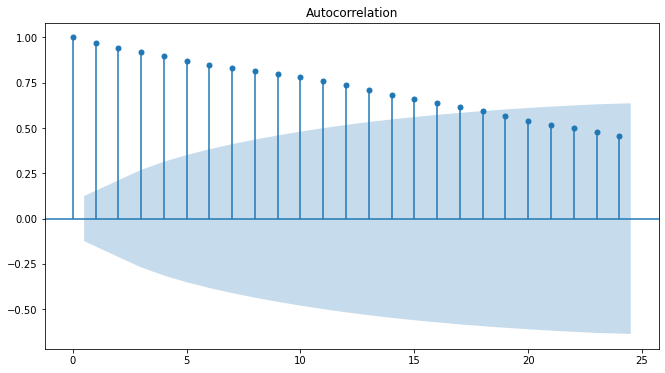

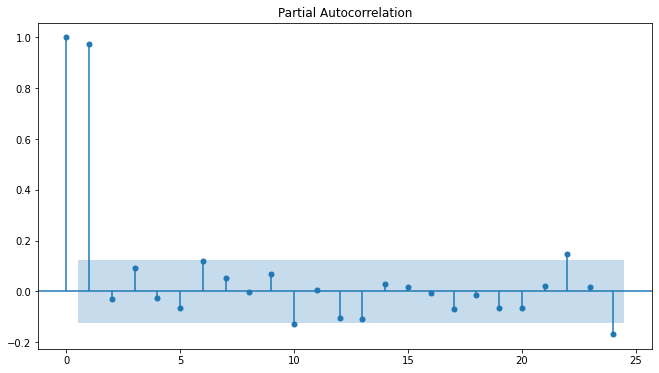

In [321]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF : 위 그래프를 보아 아주 느리게 감소하고 있다.
* PACF : 시차가 2 이상일 때 0에 가까워진다.
    
q는 적합한 값이 없기 때문에 고려하지 않고, p=2로 설정한다.    
여기서는 추가적인 실험을 위해 p=5도 시도해보려고 한다.

Results of Dickey-Fuller Test: 
Test Statistic                -1.243780e+01
p-value                        3.812476e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


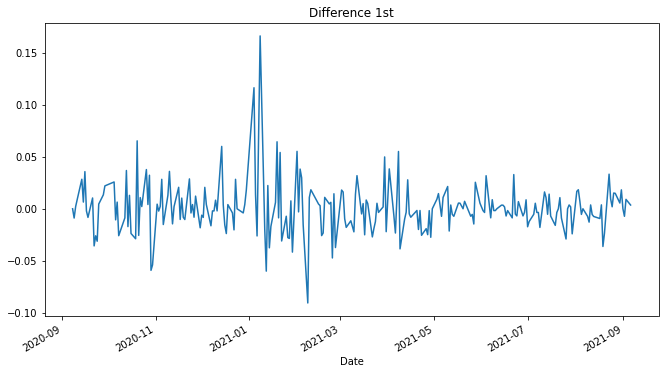

In [322]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

adf_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -9.154521e+00
p-value                        2.631686e-15
#Lags Used                     1.000000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


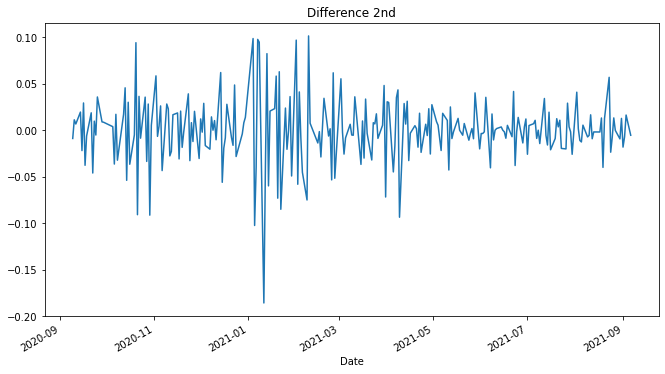

In [323]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

adf_test(diff_2)

1차 차분이 더 0에 가까우므로 d=1으로 설정한다.

#### ✅ p=2, q=0, d=1
#### ✅ p=5, q=0, d=1

## 5. 학습, 테스트 데이터셋 생성

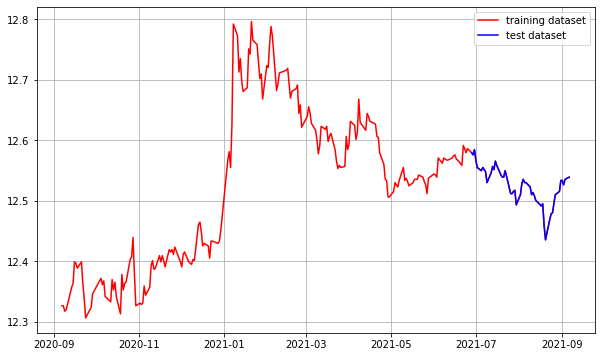

In [324]:
train_data, test_data = split_train_test(ts_log)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 6. ARIMA 모델 훈련과 테스트

#### ✅ p=2, q=0, d=1

In [325]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  197
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 433.020
Method:                       css-mle   S.D. of innovations              0.027
Date:                Mon, 06 Sep 2021   AIC                           -858.039
Time:                        16:36:12   BIC                           -844.906
Sample:                             1   HQIC                          -852.723
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.002      0.773      0.440      -0.002       0.005
ar.L1.D.Close     0.0099      0.071      0.141      0.888      -0.128       0.148
ar.L2.D.Close    -0.1238      0.070     

<Figure size 720x432 with 0 Axes>

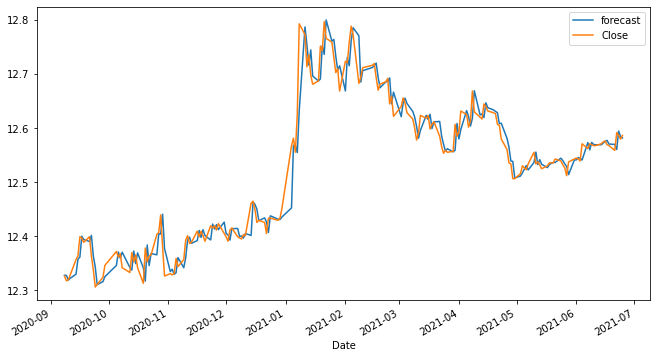

In [326]:
# ARIMA훈련 결과 시각화
plt.figure(figsize=(10,6))
fitted_m.plot_predict()
plt.show()

테스트 데이터 구간의 데이터를 예측해본다.

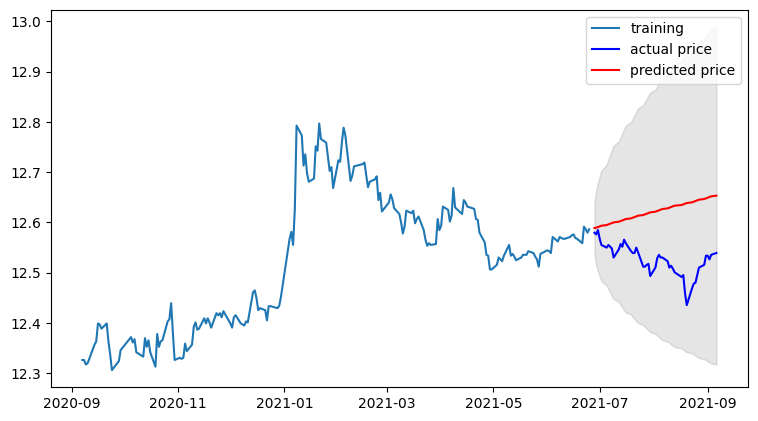

In [327]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [328]:
accuracy_measure(test_data, fc)

MSE:  907240281.4496391
MAE:  27114.49039861346
RMSE:  30120.42963587404
MAPE: 9.99%


오차율 9.99%을 보이고 있다.    
마지막으로 잔차 분석을 통해 문제가 없는지 확인한다. 잔차는 어떠한 패턴이나 특성이 나타나면 안된다.

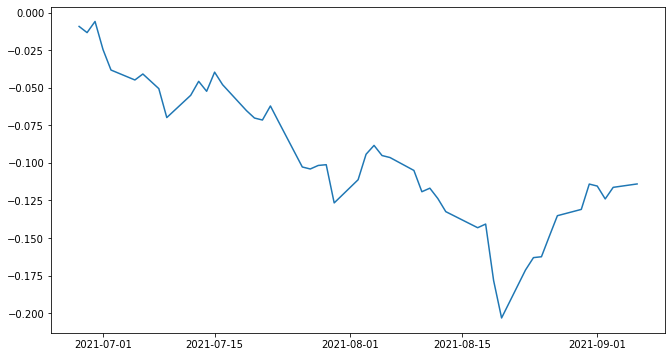

In [329]:
diff = np.array(test_data)-np.array(fc_series)
plt.plot(fc_series.index, diff)

<Figure size 720x432 with 0 Axes>

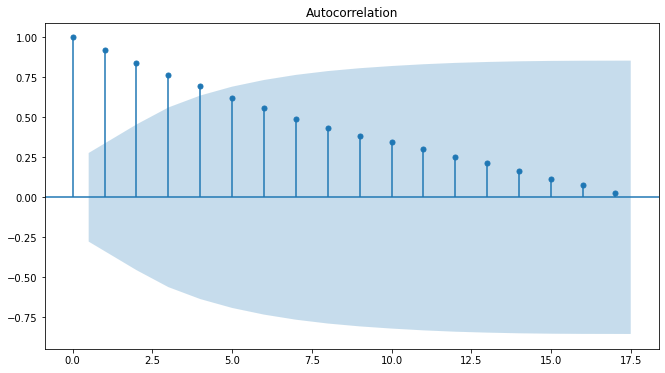

In [330]:
plt.figure(figsize=(10,6))
plot_acf(diff)
plt.show()

ACF의 그래프가 빠르게 0에 수렴하는 것을 볼 수 있다.

#### ✅ p=5, q=0, d=1

In [334]:
model = ARIMA(train_data, order=(5, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  197
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 434.549
Method:                       css-mle   S.D. of innovations              0.027
Date:                Mon, 06 Sep 2021   AIC                           -855.099
Time:                        16:37:55   BIC                           -832.116
Sample:                             1   HQIC                          -845.795
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.002      0.805      0.421      -0.002       0.005
ar.L1.D.Close     0.0166      0.071      0.234      0.815      -0.122       0.155
ar.L2.D.Close    -0.1166      0.070     

<Figure size 720x432 with 0 Axes>

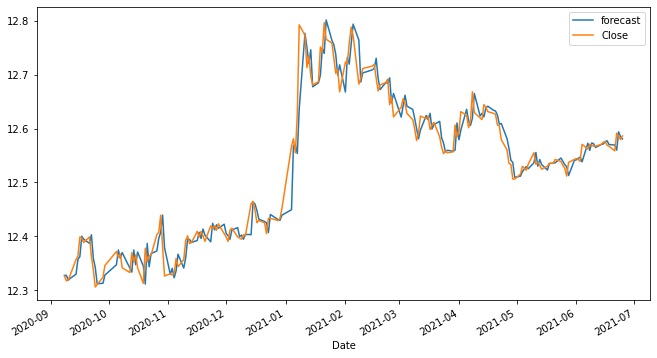

In [335]:
# ARIMA훈련 결과 시각화
plt.figure(figsize=(10,6))
fitted_m.plot_predict()
plt.show()

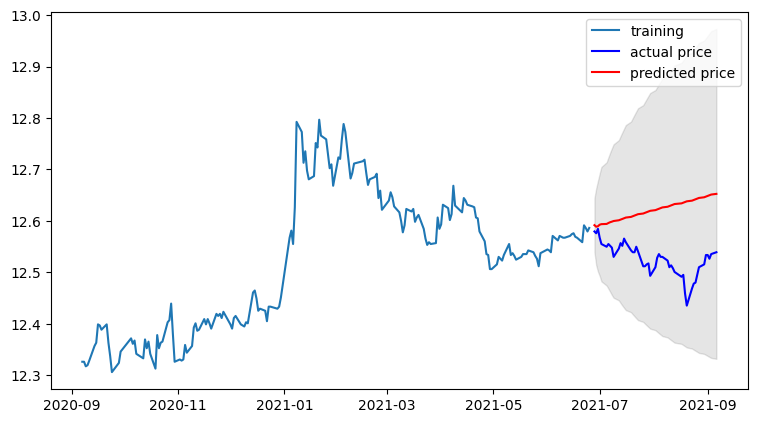

In [336]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [337]:
accuracy_measure(test_data, fc)

MSE:  901611845.5140624
MAE:  27043.496762001087
RMSE:  30026.85207466914
MAPE: 9.96%


p=2, q=0, d=1 의 MAPE가 9.99%였으나 p=5, q=0, d=1의 MAPE가 9.96%으로 감소하는 형태를 보였다.    
마지막으로 잔차 분석을 통해 문제가 없는지 확인한다. 잔차는 어떠한 패턴이나 특성이 나타나면 안된다.

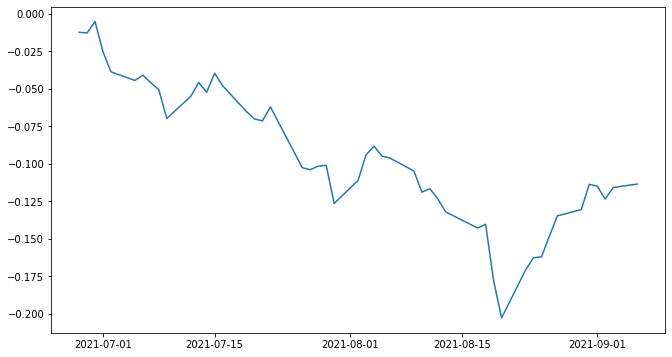

In [338]:
diff = np.array(test_data)-np.array(fc_series)
plt.plot(fc_series.index, diff)

<Figure size 720x432 with 0 Axes>

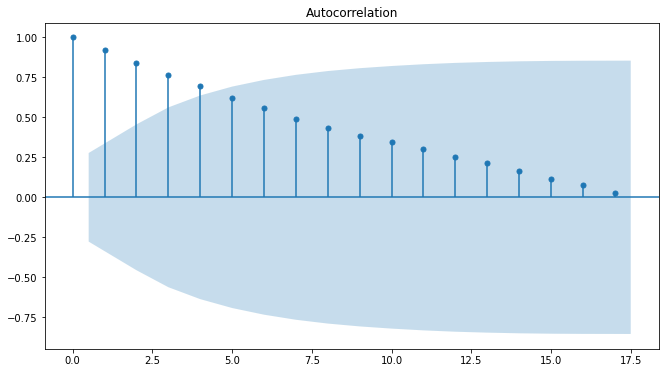

In [339]:
plt.figure(figsize=(10,6))
plot_acf(diff)
plt.show()

ACF의 그래프가 빠르게 0에 수렴하는 것을 볼 수 있다.

### 최종적으로 예측한 값
p=5, q=0, d=1 일때의 ARIMA 모델
MAPE: 9.96

# 회고 
## 배운 점
* Adsp 공부할 때 귀무가설을 배우면서 이걸 어디에서 사용할까 했는데 이번에 그 사용법을 알게 되었다.
* 시계열 데이터를 추세와 계절성, residual로 나눌 수 있다는 것을 배웠다.
* 주식을 예측하는 법을 배웠다.

## 느낀 점
* 통계적인 지식이 부족해서 개념이 많이 어려웠다.
* 주식을 예측하는 법을 배웠으니 실생활에 사용할 수 있을까?? 로망을 하나 이룬 기분이다.
* ARIMA의 Summary를 읽을 줄 알면 더 좋았겠지만... 천천히 공부해나가도록 하자.

# Reference
* https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80